In [47]:
#standard ds imports
import pandas as pd
import numpy as np
import os

# acquire imports
import acquire_zillow

#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#import sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.preprocessing

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# MODELING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

In [57]:
# ACQUIRE DATA
df = acquire_zillow.get_zillow_data()

In [3]:
# PREPARE DATA
df = acquire_zillow.prep_zillow(df)

In [ ]:
# EXPLORE DATA

Initial Hypothesis:

The number of bathrooms and bedrooms and square footage can be used to create a regression model 
that outperforms the baseline model.

In [4]:
# SPLIT DATA

In [5]:
train, validate, test = acquire_zillow.split_zillow(df)

In [6]:
train.shape, validate.shape, test.shape

((33477, 4), (11159, 4), (11160, 4))

Which feature has the strongest impact -- square footage, number of bedrooms or number of bathrooms?

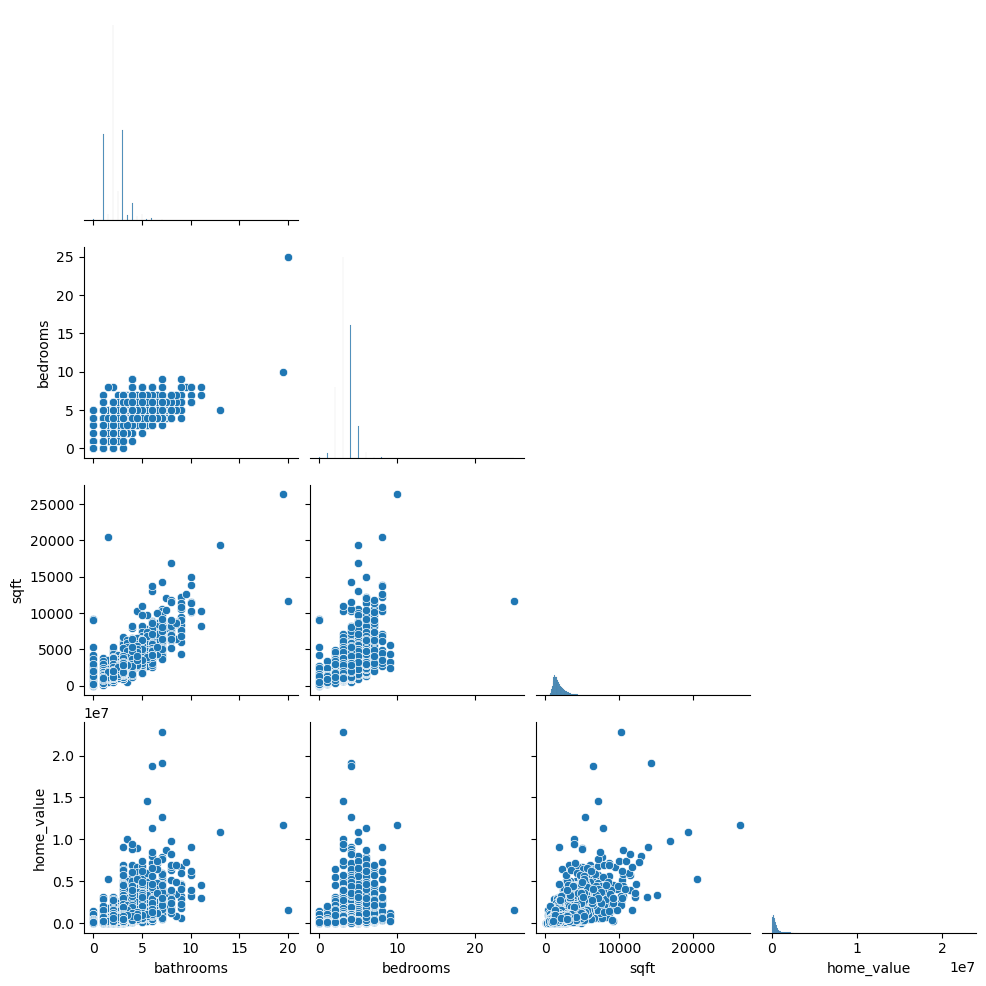

In [7]:
sns.pairplot(train[['bathrooms', 'bedrooms', 'sqft', 'home_value']], corner=True)
plt.show()

In [8]:
# Upon preliminary analysis, square footage and number of bathrooms have a stronger impact 
# on home value than how many bedrooms it has.

In [9]:
from scipy.stats import pearsonr, spearmanr

In [12]:
# Create the correlation matrix for each feature
feature_corr = train.corr(method='spearman')

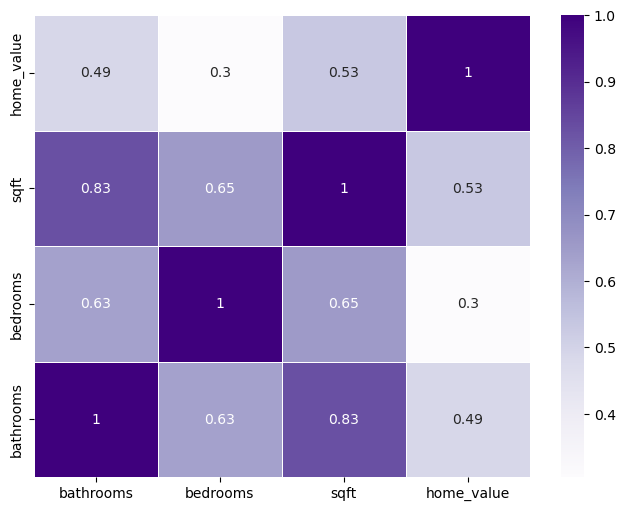

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(feature_corr, cmap='Purples', annot=True, linewidth=0.5)
plt.ylim(0, 4)

plt.show()

In [13]:
# INTERPRETATION: Square feet has the highest correlation to home value. It also has a stronger
# correlation to other home features (i.e. number of bedrooms and bathrooms) than they do to each other.

In [ ]:
# SCALING DATA

In [14]:
# 1. create the object
scaler = sklearn.preprocessing.RobustScaler()

# 2. fit the object
scaler.fit(train[['bathrooms', 'bedrooms', 'sqft', 'home_value']])

# 3. use the object
train[['bathrooms_scaled', 'bedrooms_scaled', 'sqft_scaled', 'home_value_scaled']] = scaler.transform(train[['bathrooms', 'bedrooms', 'sqft', 'home_value']])
test[['bathrooms_scaled', 'bedrooms_scaled', 'sqft_scaled', 'home_value_scaled']] = scaler.transform(test[['bathrooms', 'bedrooms', 'sqft', 'home_value']])
validate[['bathrooms_scaled', 'bedrooms_scaled', 'sqft_scaled', 'home_value_scaled']] = scaler.transform(validate[['bathrooms', 'bedrooms', 'sqft', 'home_value']])

In [ ]:
# FEATURE ENGINEERING

In [17]:
from sklearn.feature_selection import SelectKBest, f_regression

In [19]:
X_train_scaled, y_train = train[['bathrooms_scaled', 'bedrooms_scaled', 'sqft_scaled']], train.home_value_scaled
f_selector = SelectKBest(f_regression, k=2)
f_selector.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x159a03ec0>)

In [20]:
# MAKE the thing
kbest = SelectKBest(f_regression, k=2)

# FIT the thing
kbest.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x159a03ec0>)

In [22]:
kbest.scores_
kbest.pvalues_
kbest.feature_names_in_
kbest_results = pd.DataFrame(
                dict(p=kbest.pvalues_, f=kbest.scores_),
                                        index = X_train_scaled.columns)
kbest_results

,p,f
bathrooms_scaled,0.0,14090.246904
bedrooms_scaled,0.0,2821.722215
sqft_scaled,0.0,24334.057827


In [58]:
# Select KBest: Square feet and number of bathrooms have the highest feature score.

In [ ]:
# EVALUATING DATA

In [48]:
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [49]:
train['yhat_baseline'] = train['home_value_scaled'].mean()

In [50]:
# generate parameters, i.e. create model
ols_model = LinearRegression().fit(train[['bathrooms_scaled', 'bedrooms_scaled', 'sqft_scaled']], train['home_value_scaled'])

    # compute predictions and add to original dataframe
train['yhat'] = ols_model.predict(train[['bathrooms_scaled', 'bedrooms_scaled', 'sqft_scaled']])

In [51]:
# compute residuals
train['residual'] = train['yhat'] - train['home_value_scaled']
train['residual_baseline'] = train['yhat_baseline'] - train['home_value_scaled']

In [65]:
# Fit a linear regression model (ordinary least squares) 
    # create the object
lm = LinearRegression()
    # fit the object
lm.fit(X, y)
    # use the object
yhat = lm.predict(X) 

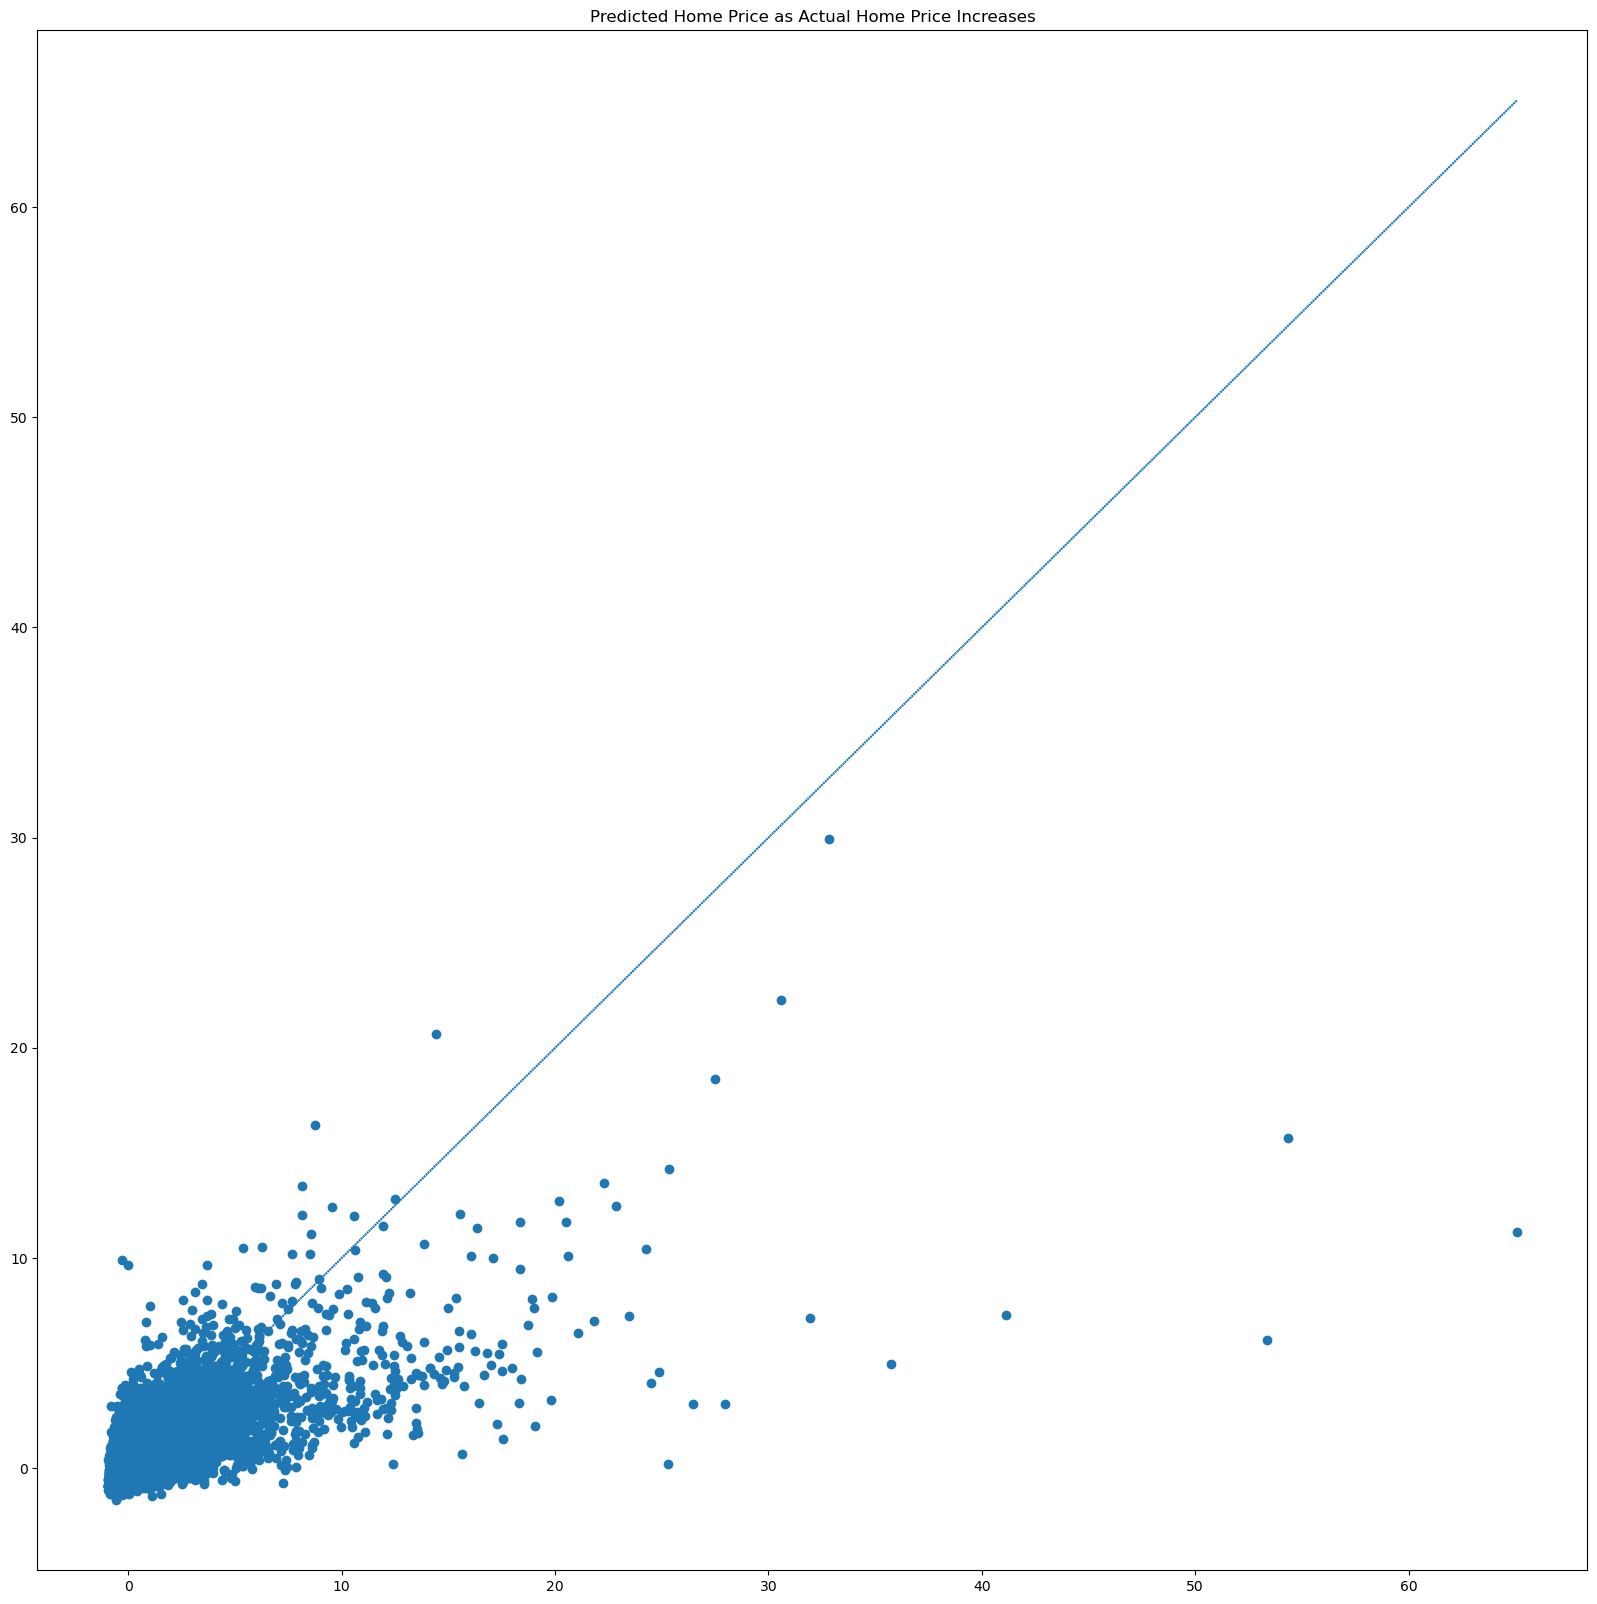

In [68]:
# plot residuals
plt.figure(figsize=(20,20))
plt.scatter(y, yhat)
plt.plot(y,y, ls=':')
plt.title('Predicted Home Price as Actual Home Price Increases')
plt.show()

In [52]:
    # Now, we will use the residuals to compute the Sum of Squared Errors
    # square each residual value
train['residual^2'] = train.residual ** 2

train['residual_baseline^2'] = train.residual_baseline ** 2

In [53]:
# SSE (Sum of Squared Errors)
SSE = sum(train['residual^2'])
SSE_baseline = sum(train['residual_baseline^2'])

print("SSE = ", SSE)
print("SSE - baseline = ", SSE_baseline)

SSE =  52974.89802818282
SSE - baseline =  95161.68124931047


In [ ]:
 # It appears the model is performing better than the baseline.

In [54]:
# MSE (Mean Squared Error)
MSE = SSE/len(df)
MSE_baseline = SSE_baseline/len(df)

print("MSE = ", MSE)
print("MSE baseline = ", MSE_baseline)

MSE =  0.9494389925475449
MSE baseline =  1.70552873412629


In [42]:
# It is clear the model is performing better than the baseline.

In [55]:
# RMSE (Root Mean Squared Error)
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline = sqrt(MSE_baseline)

print("RMSE = ", RMSE)
print("RMSE baseline = ", RMSE_baseline)

RMSE =  0.9743916012299906
RMSE baseline =  1.3059589327870498


In [44]:
# INTERPRETATION: The OLS model is off by an average of 0.97, while the baseline is off by an average of 1.3. 
# The OLS model does better than having no model at all.

In [71]:
# Fit a linear regression model (LassoLars)

X = train[['bathrooms_scaled', 'bedrooms_scaled', 'sqft_scaled']]
y = train['home_value_scaled']
    # create the object
lars = LassoLars(alpha=1.0)
    # fit the object
lars.fit(X, y)
    # use the object
yhat = lars.predict(X) 

In [72]:
y_pred = pd.DataFrame(
{
    'y_act': y.values,
    'yhat': yhat,
    'mean_baseline' : mean_baseline,
    'med_baseline': med_baseline
}, index=train.index)

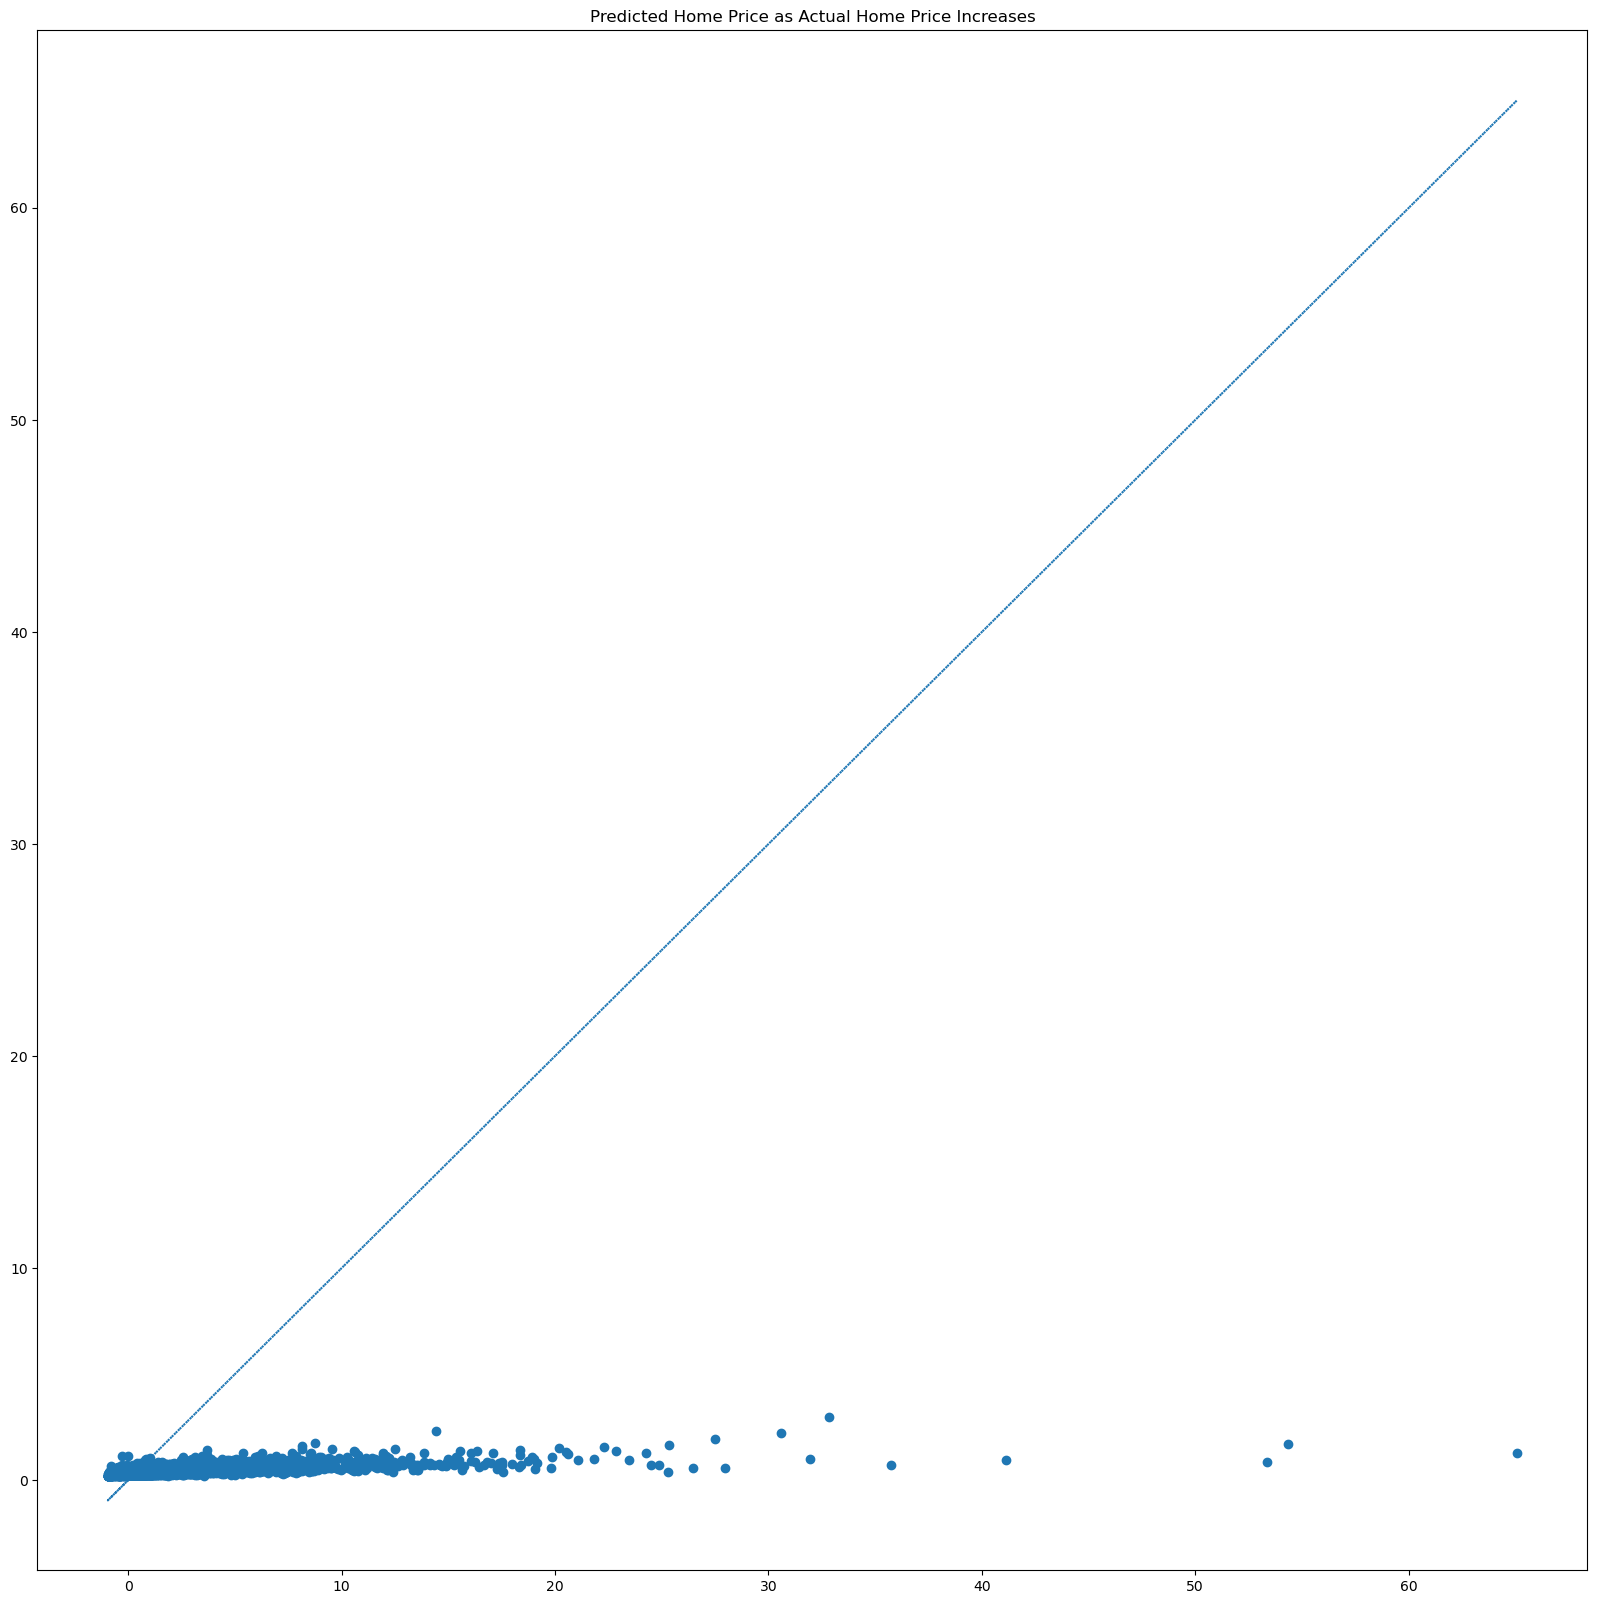

In [73]:
y = train['home_value_scaled']
yhat = lars.predict(X)

plt.figure(figsize=(20,20))
plt.scatter(y, yhat)
plt.plot(y,y, ls=':')
plt.title('Predicted Home Price as Actual Home Price Increases')
plt.show()

In [ ]:
# INTERPRETATION: LassoLars does not perform as well as OLS for predicting property tax assessed values.

RECOMMENDATIONS:

-- Deploy OLS regression model to predict property tax assessed values.

NEXT STEPS:

-- Additional modeling in progress (TweedieRegression, Polynomial Regression) to test for further improvements.